# Final Project:  Edge-based Generative Model

## A.  Problem:  Gas utility organization looking for a tool to help investigate progression of surface damage on gas pipes.

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/18OsVUxn3kl6N2tKaaJzfRqSLOeUTekkd/preview" width="220" height="220"></iframe>

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1lLuuRXVlOW4sPKa7JBT8s5M3TCuSP5NR/preview" width="220" height="180"></iframe>

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1lGTlEqcXLS6keac6khrUP27tHXGTwJyN/preview" width="220" height="180"></iframe>

## B.  Objective:  Generate a baseline generative model that will provide visual insights on surface damage migration patterns on gas pipes.

## C.  Solution: Generative Adversarial Network (GAN) model 

### Implementation Details: <br>
Model:  CycleGAN from Tensorflow-Keras <br>
Training Data:  Curated good and damaged pipes from public websites <br>
Framework:  Tensorflow-Keras converted to Tensorflow Lite <br>
Edge Device:  Coral USB Accelerator

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ysf7uusl
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ysf7uusl
  Created wheel for tensorflow-examples: filename=tensorflow_examples-7b6bdb36328b9d14c4e0fbe057be465242b1210c_-cp36-none-any.whl size=157027 sha256=964e0f05205990ab1df261b95ad9b9f5475e469da9429b45327c5a2c49597bfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-xwuz04kb/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
!rm -r /content/pipegan
!rm -r /content/checkpoints
!rm /content/pipegan.tflite

rm: cannot remove '/content/pipegan': No such file or directory
rm: cannot remove '/content/checkpoints': No such file or directory
rm: cannot remove '/content/pipegan.tflite': No such file or directory


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

## 1.  Input Pipeline (Image domains for good and damaged pipes)

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
#  input_image = image[:, w:, :]

#  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

#  return input_image, real_image
  return real_image

In [ ]:
def load_image_train(image_file):
  real_image = load(image_file)
  real_image = random_jitter(real_image)
  real_image = normalize(real_image)

  return real_image

In [ ]:
from google.colab import drive
drive.mount('/content/gandrive',force_remount=True)

Mounted at /content/gandrive


In [ ]:
PATH = '/content/gandrive/MyDrive/Colab Notebooks/MSDS462/FinalProject/dataset/datasetPipe/'
train_goodpipes = tf.data.Dataset.list_files(PATH+'testA/*.jpeg')
train_goodpipes = train_goodpipes.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_goodpipes = train_goodpipes.shuffle(BUFFER_SIZE)
train_goodpipes = train_goodpipes.batch(BATCH_SIZE)

train_dampipes = tf.data.Dataset.list_files(PATH+'testB/*.jpeg')
train_dampipes = train_dampipes.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dampipes = train_dampipes.shuffle(BUFFER_SIZE)
train_dampipes = train_dampipes.batch(BATCH_SIZE)

In [ ]:
sample_goodpipe = next(iter(train_goodpipes))
sample_dampipe = next(iter(train_dampipes))

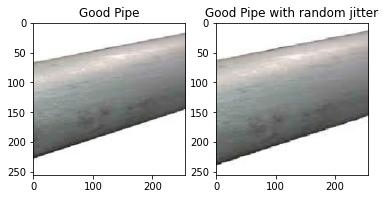

In [ ]:
plt.subplot(121)
plt.title('Good Pipe')
plt.imshow(sample_goodpipe[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Good Pipe with random jitter')
plt.imshow(random_jitter(sample_goodpipe[0]) * 0.5 + 0.5)

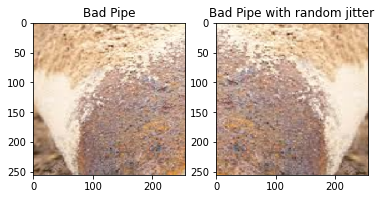

In [ ]:
plt.subplot(121)
plt.title('Bad Pipe')
plt.imshow(sample_dampipe[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Bad Pipe with random jitter')
plt.imshow(random_jitter(sample_dampipe[0]) * 0.5 + 0.5)

## 2.  Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


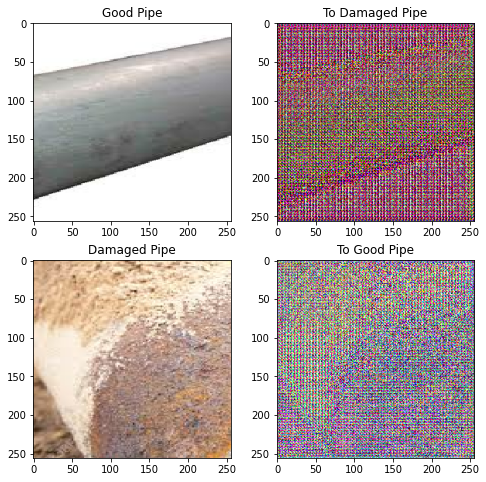

In [ ]:
to_dampipe = generator_g(sample_goodpipe)
to_goodpipe = generator_f(sample_dampipe)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_goodpipe, to_dampipe, sample_dampipe, to_goodpipe]
title = ['Good Pipe', 'To Damaged Pipe', 'Damaged Pipe', 'To Good Pipe']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

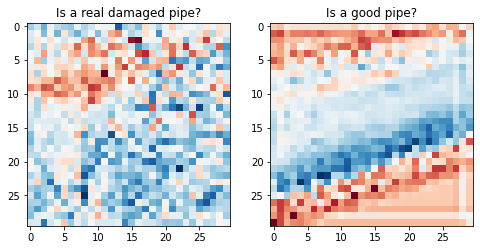

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real damaged pipe?')
plt.imshow(discriminator_y(sample_dampipe)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a good pipe?')
plt.imshow(discriminator_x(sample_goodpipe)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [ ]:
EPOCHS = 200
#EPOCHS = 1000
#EPOCHS = 1

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return total_gen_g_loss,total_gen_f_loss,disc_x_loss,disc_y_loss

## 3.  Convert Generator to Tflite

In [ ]:
def convert_to_tflite(saved_model_path, tflite_model_path):
    model = tf.saved_model.load(saved_model_path)
    concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    concrete_func.inputs[0].set_shape([1, 256, 256, 3])
    concrete_func.outputs[0].set_shape([1, 256, 256, 3])
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print('Fixed-point Quantized model:', tflite_model_path, 
        'Size:', len(tflite_model) / 1024, "kb")

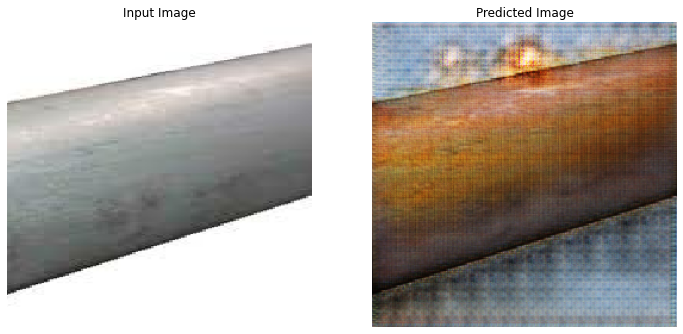

INFO:tensorflow:Assets written to: pipegan/assets


INFO:tensorflow:Assets written to: pipegan/assets


Fixed-point Quantized model: pipegan.tflite Size: 155383.15625 kb
Saving checkpoint and model for epoch 200 at ./checkpoints/train/ckpt-40 and pipegan.tflite
Time taken for epoch 200 is 33.30542850494385 sec

Loss: GenGood - 3.2459702491760254 GenDam - 5.126840591430664 
 DiscrGood - 0.7205215096473694 DiscrDam - 0.7266067862510681


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
#  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
  for image_x, image_y in tf.data.Dataset.zip((train_goodpipes, train_dampipes)):
    total_gen_g_loss,total_gen_f_loss,disc_x_loss,disc_y_loss = train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_goodpipe) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_goodpipe)

  if (epoch + 1) % 5 == 0:
  #if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    generator_g.save('pipegan')
    convert_to_tflite('/content/pipegan/', 'pipegan.tflite')
    print ('Saving checkpoint and model for epoch {} at {} and {}'.format(epoch+1,
                                                         ckpt_save_path, 'pipegan.tflite'))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
  print ('Loss: GenGood - {} GenDam - {} \n DiscrGood - {} DiscrDam - {}'.format(total_gen_g_loss,
                                                                                 total_gen_f_loss,disc_x_loss,disc_y_loss))

## Generate using test dataset

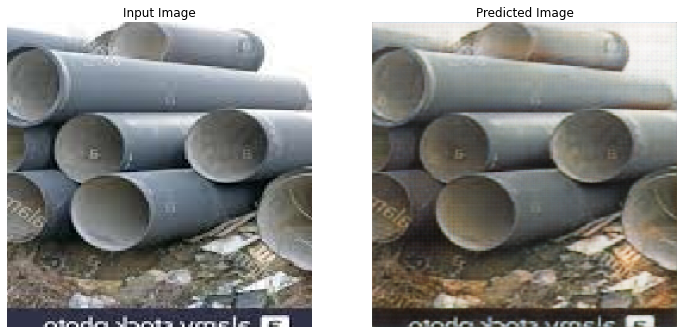

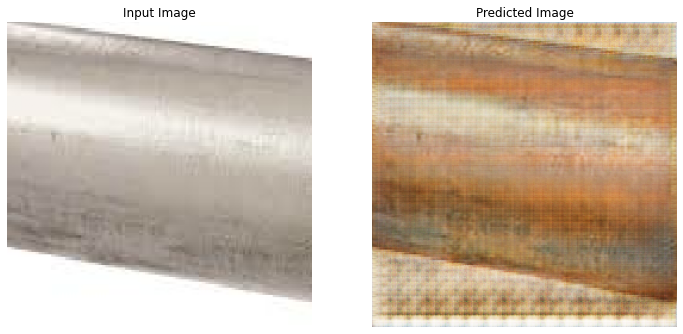

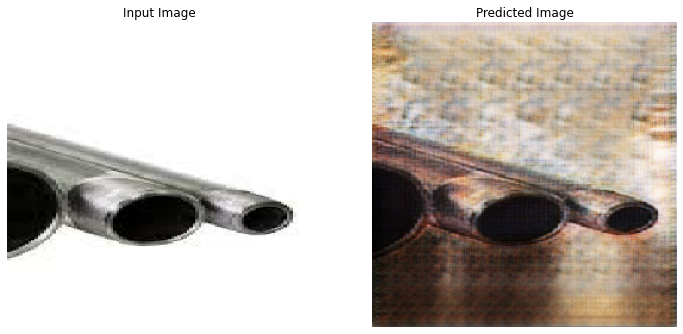

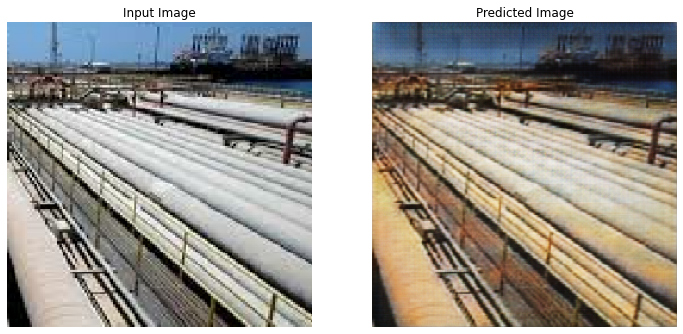

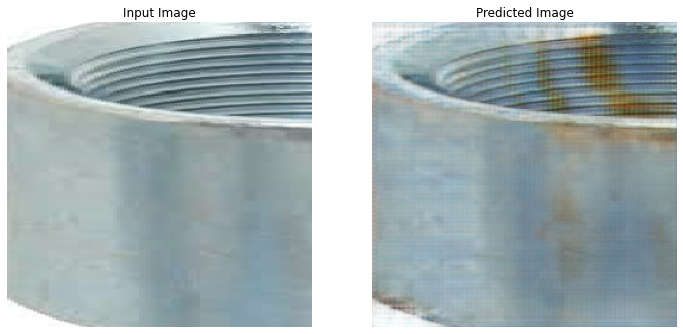

In [ ]:
# Run the trained model on the test dataset
for inp in train_goodpipes.take(5):
  generate_images(generator_g, inp)

## Gather a Test Image

In [ ]:
def load_image(path):
  image_raw = tf.io.read_file(path)
  image = tf.image.decode_image(image_raw, channels=3)
  return image

## View the input image

(195, 259, 3)


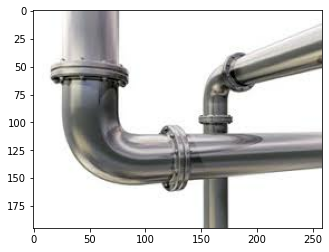

In [ ]:
#test_image_original = load_image("/content/gandrive/My Drive/Colab Notebooks/MSDS462/FinalProject/horse.jpg")
#test_image_original = load_image("h26CpAPb_400x400.jpg")
test_image_original = load_image("/content/gandrive/MyDrive/Colab Notebooks/MSDS462/FinalProject/dataset/datasetPipe/testA/good13.jpeg")
print(test_image_original.shape)
plt.imshow(test_image_original)
plt.show()

## Preprocess the image

In [ ]:
def resize(image):
    #resized_image =  tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #resized_image = tf.cast(resized_image, tf.float32)
    resized_image = preprocess_image_train(image,'')
    #resized_image = preprocess_image_test(image,'')
    resized_image = tf.expand_dims(resized_image, 0)

    return resized_image

In [ ]:
test_image_resized = resize(test_image_original)
test_image_resized

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0.7490196 , 0.73333335, 0.7411765 ],
         [0.7411765 , 0.7254902 , 0.73333335],
         [0.75686276, 0.7411765 , 0.7490196 ],
         ...,
         [1.        , 1.        , 0.9843137 ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.67058825, 0.6627451 , 0.64705884],
         [0.6627451 , 0.654902  , 0.6392157 ],
         [0.67058825, 0.6627451 , 0.64705884],
         ...,
         [1.        , 1.        , 0.9843137 ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.67058825, 0.6627451 , 0.64705884],
         [0.6627451 , 0.654902  , 0.6392157 ],
         [0.67058825, 0.6627451 , 0.64705884],
         ...,
         [1.        , 1.        , 0.9843137 ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 

## 4.  Run inference on preprocessed image

In [ ]:
with tf.io.gfile.GFile('pipegan.tflite', 'rb') as f:
    model_content = f.read()

# Initialze TensorFlow Lite interpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

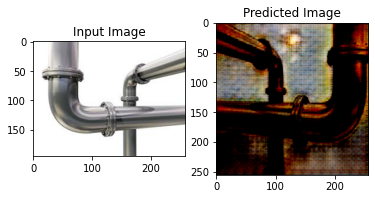

In [ ]:
# Set model input
interpreter.set_tensor(input_index, test_image_resized)

# Run inference
interpreter.invoke()

# Visualize results
plt.subplot(121)
plt.title('Input Image')
plt.imshow(test_image_original)

plt.subplot(122)
plt.title('Predicted Image')
plt.imshow(output()[0])

In [ ]:
output()[0]

array([[[ 0.33873415,  0.23577042,  0.13587862],
        [ 0.38511446,  0.19768625,  0.04151314],
        [ 0.38753358,  0.2004823 ,  0.03706605],
        ...,
        [ 0.46882886,  0.2999058 ,  0.2042482 ],
        [ 0.49580976,  0.31587148,  0.28422996],
        [ 0.51193243,  0.4031998 ,  0.3670725 ]],

       [[ 0.46402007,  0.23131515,  0.00603532],
        [ 0.4690705 ,  0.22480066, -0.01852661],
        [ 0.50174767,  0.25688618, -0.08399168],
        ...,
        [ 0.60582584,  0.35980803,  0.24472302],
        [ 0.5551023 ,  0.40167072,  0.2753294 ],
        [ 0.57300895,  0.5158509 ,  0.37153408]],

       [[ 0.38226363,  0.1548035 , -0.16218269],
        [ 0.34477797, -0.0393476 , -0.1444337 ],
        [ 0.2903832 ,  0.02846471, -0.22910118],
        ...,
        [ 0.57142955,  0.30465356,  0.13052368],
        [ 0.5257706 ,  0.3854729 ,  0.21862982],
        [ 0.567821  ,  0.39940137,  0.37471327]],

       ...,

       [[ 0.15010534, -0.05264974,  0.04774456],
        [ 0